In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import pandas as pd

import sys
sys.path.append("../../") # go to parent dir so we can import `speech2phone`
from speech2phone.preprocessing import get_TIMIT, get_phones
from speech2phone.preprocessing.filters import mel

import mag

ImportError: cannot import name 'get_TIMIT'

# Load data

In [ ]:
# to recreate cache (if you've modified the preprocessor), add `use_cache=False
X_toy, y_toy = get_TIMIT(dataset='toy', preprocessor=mel, TIMIT_root='../TIMIT/TIMIT')
X_train, y_train = get_TIMIT(dataset='train', preprocessor=mel, TIMIT_root='../TIMIT/TIMIT')
X_test, y_test = get_TIMIT(dataset='val', preprocessor=mel, TIMIT_root='../TIMIT/TIMIT')

## One-hot encoding

By default, outputs are categorical (ints).

In [3]:
thing = np.unique(y_toy)
print(thing, len(thing))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60] 61


You can change it to one-hot encoding like this:

In [4]:
_, thing = get_TIMIT(dataset='toy', preprocessor=mel, TIMIT_root='../TIMIT/TIMIT', y_type='one-hot')
thing = np.flip(np.unique(thing, axis=0), axis=0)
print(thing, len(thing))

# and this is how you get phoneme labels back
print(get_phones(np.argmax(thing, axis=0)))

Loading toy/mel set from cache... done.
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 61
['aa' 'ae' 'ah' 'ao' 'aw' 'ax' 'ax-h' 'axr' 'ay' 'b' 'bcl' 'ch' 'd' 'dcl'
 'dh' 'dx' 'eh' 'el' 'em' 'en' 'eng' 'epi' 'er' 'ey' 'f' 'g' 'gcl' 'h#'
 'hh' 'hv' 'ih' 'ix' 'iy' 'jh' 'k' 'kcl' 'l' 'm' 'n' 'ng' 'nx' 'ow' 'oy'
 'p' 'pau' 'pcl' 'q' 'r' 's' 'sh' 't' 'tcl' 'th' 'uh' 'uw' 'ux' 'v' 'w'
 'y' 'z' 'zh']


# GDA

In [5]:
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, y_train)
model.score(X_test, y_test)

/home/kylrth/.anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.38844207482378457

# Random Forest

In [5]:
rf = RandomForestClassifier(n_estimators=20, max_depth=30, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.3676802819446955

# XGBoost

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {"max_depth": 20, 
          "eta": 0.3, 
          "num_class": 61, 
          "gamma": 1, 
          "lambda": 10, 
          "alpha": 10}
params["objective"] = "multi:softmax"
params["eval_metric"] = "merror"
params['nthread'] = 4
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [7]:
num_round = 1
bst = xgb.train(params, dtrain, num_round, evallist)
y_pred = bst.predict(dtest)
score = sum(y_pred == y_test) / len(y_test)
print(score)

[12:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 94 pruned nodes, max_depth=17
[12:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 94 pruned nodes, max_depth=17
[12:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 132 pruned nodes, max_depth=20
[12:33:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 72 pruned nodes, max_depth=20
[12:33:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 70 pruned nodes, max_depth=20
[12:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 198 pruned nodes, max_depth=20
[12:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 68 pruned nodes, max_depth=10
[12:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 174 pruned nodes, max_depth=20
[12:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra n

# PCA

In [8]:
class PCA:
    def __init__(self, X, y=None, s=None, sparse=False, center=True):
        self.X = X - X.mean(axis=0) if center else X
        self.y = y
        self.sparse = sparse
        if s == None:
            n, d = X.shape
            s = d
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            self.y_dict = {}
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def update_s(self, s):
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def transform(self, x):
        return self.Vh@x.T
    
    def project(self, x):
        return self.Vh.T@self.a
    
    def predict(self, x):
        a_test = self.Vh @ x.T
        predicted = []
        for a in a_test.T:
            similarities = []
            for key, value in self.y_dict.items():
                similarity = np.dot(a, value) / (la.norm(a)*la.norm(value))
                similarities.append((similarity, key))
            predicted.append(max(similarities, key=lambda x: x[0])[1])
        return predicted

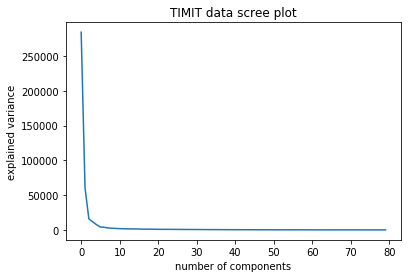

In [9]:
pca_timit = PCA(X_train, y=y_train)
n, d = X_train.shape
fig = plt.figure()
plt.plot(np.arange(d), pca_timit.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("TIMIT data scree plot")
plt.show()
# print(pca_timit.sig / pca_timit.sig.sum())
i = 1
p = 0
while p < .9:
    p = np.sum(pca_timit.sig[:i]) / np.sum(pca_timit.sig)
#     print(i, p)
    i+=1

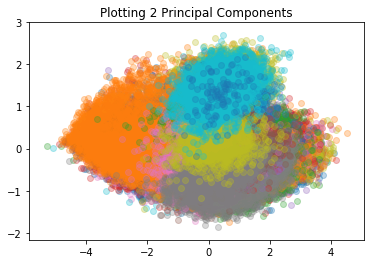

In [10]:
pca_timit.update_s(2)
A = np.vstack([pca_timit.a, pca_timit.y])
for i in np.unique(y_train):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], alpha=0.3)
plt.title("Plotting 2 Principal Components")
plt.show()

In [11]:
pca_train = PCA(X_train, y=y_train, s=20, center=False)
y_pred = pca_train.predict(X_test)
pca_score = sum(y_pred == y_test) / len(y_test)
print("PCA accuracy: {:.3f}".format(pca_score))

PCA accuracy: 0.212
